# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events
import pickle
# Import Module
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, run_scenario, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm_both, track_system_stock, track_system_emission
import libcbm

## Create and Run `ForestModel` instance

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'redchris'

In [3]:
fm = ws3.forest.ForestModel(model_name='redchris',
                            model_path='./data/woodstock_model_files_redchris_test',
                            # model_path='./data/woodstock_model_files_redchris',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [4]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

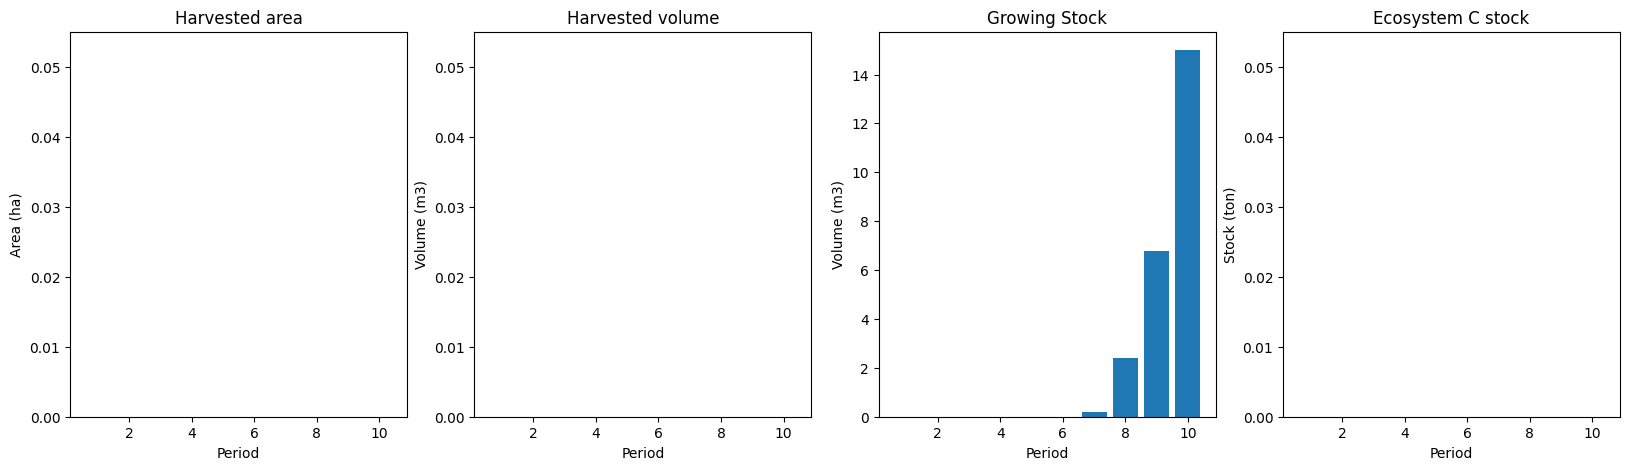

In [5]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [6]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [7]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [8]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [9]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [10]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]


npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

# decay_emissions_fluxes = [
#     'DecayVFastAGToAir',
#     'DecayVFastBGToAir',
#     'DecayFastAGToAir',
#     'DecayFastBGToAir',
#     'DecayMediumToAir',
#     'DecaySlowAGToAir',
#     'DecaySlowBGToAir',
#     'DecaySWStemSnagToAir',
#     'DecaySWBranchSnagToAir',
#     'DecayHWStemSnagToAir',
#     'DecayHWBranchSnagToAir'
# ]
ecosystem_decay_emissions_pools = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]
grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

ecosystem_decay_emissions_pools = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']
GrossGrowth_pools = [
    'DeltaBiomass_AG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'DeltaBiomass_BG',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput']

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [11]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
# fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
# gross_growth = grossgrowth_ag + grossgrowth_bg
fluxes = ecosystem_decay_emissions_pools
gross_growth = GrossGrowth_pools
sum_pools = ['ecosystem', 'biomass', 'DOM']

Biomass         DOM   Ecosystem  All_Emissions  Gross_Growth  \
Year                                                                   
0      0.000062  104.467724  104.467786       0.000000      0.000000   
1      0.000499  102.039676  102.040175       2.428086      0.000474   
2      0.001684   99.785821   99.787505       2.254000      0.001330   
3      0.003990   97.678510   97.682500       2.107691      0.002686   
4      0.007793   95.697510   95.705303       1.981786      0.004589   
...         ...         ...         ...            ...           ...   
96    34.223901   67.995974  102.219875       1.879514      2.571400   
97    34.638122   68.265614  102.903736       1.897099      2.580960   
98    35.050318   68.530245  103.580563       1.913676      2.590503   
99    35.460575   68.790626  104.251201       1.929382      2.600020   
100   35.909715   69.047898  104.957613       1.944396      2.650808   

      Stock_Change  
Year                
0         0.000000  
1         2.427612  
2         2.252670  
3         2.105005  
4         1.977197  
...            ...  
96       -0.691886  
97       -0.683861  
98       -0.676827  
99       -0.670638  
100      -0.706412  

[101 rows x 6 columns]

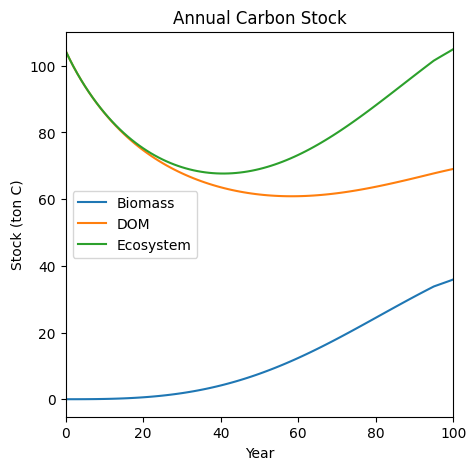

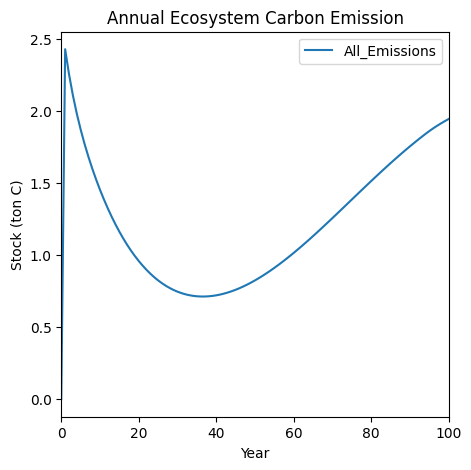

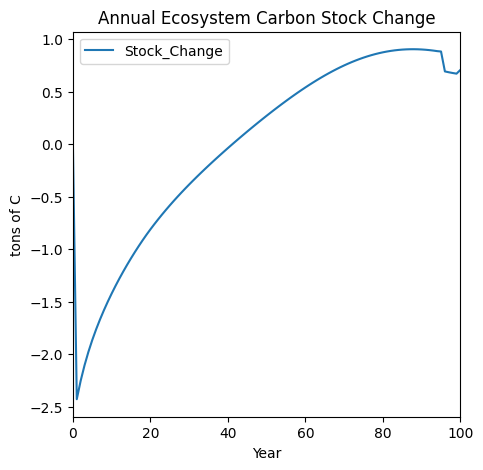

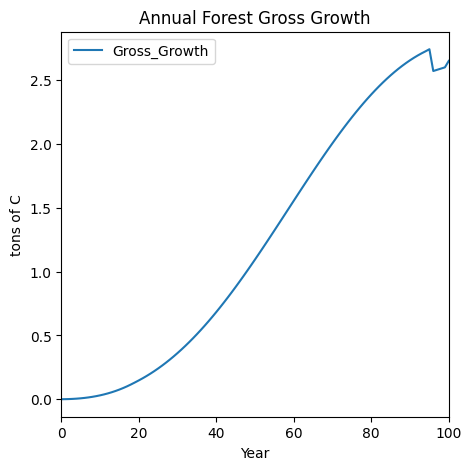

In [12]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Plug-in Carbon Yield Curves

In [13]:
# Read curves
c_curves_p = pd.read_pickle("./redchris_c_curves_p_test.pkl")
# c_curves_p = pd.read_pickle("./redchris_c_curves_p_exactmatch.pkl")
c_curves_f = pd.read_pickle("./redchris_c_curves_f_test.pkl")

In [14]:
# Plug carbon yield curves into forest model
# plugin_c_curves(fm, c_curves_p, pools=sum_pools)
plugin_c_curves_both(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_emissions', 'total_emissions', 'gross_growth'])

found match for mask ('?', '?', '?', '?', '7', '7')


In [15]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '7', '7'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7efc1373ee60>),
   ('ecosystem', <ws3.core.Curve at 0x7efc0d9ae8f0>),
   ('biomass', <ws3.core.Curve at 0x7efc0d9aea40>),
   ('DOM', <ws3.core.Curve at 0x7efc0d9ad5a0>),
   ('net_emissions', <ws3.core.Curve at 0x7efc0d9aeb30>),
   ('total_emissions', <ws3.core.Curve at 0x7efc0d9af1f0>),
   ('gross_growth', <ws3.core.Curve at 0x7efc0d9af340>)]),
 (('?', '?', '?', '?', '?', '?'),
  'c',
  [('totvol', '_SUM(s0100)'),
   ('swdvol', '_SUM(s0100)'),
   ('hwdvol', '_SUM()')])]

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

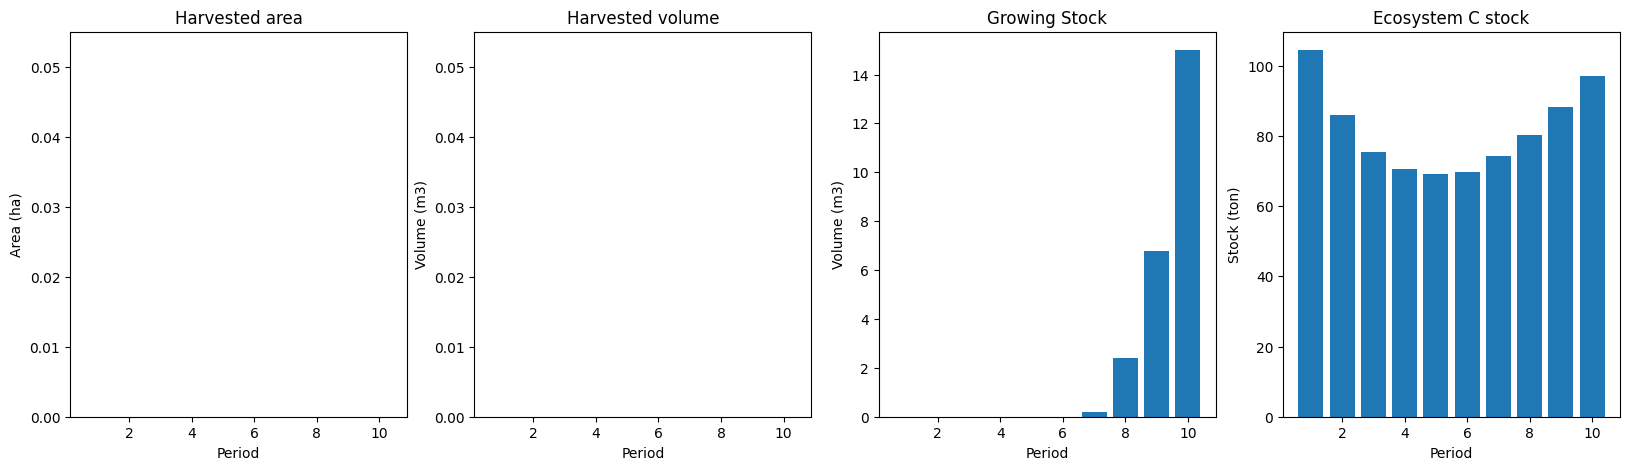

In [16]:
# Check the Forest Inventory of the ws3 Model without harvesting
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## No-harvest

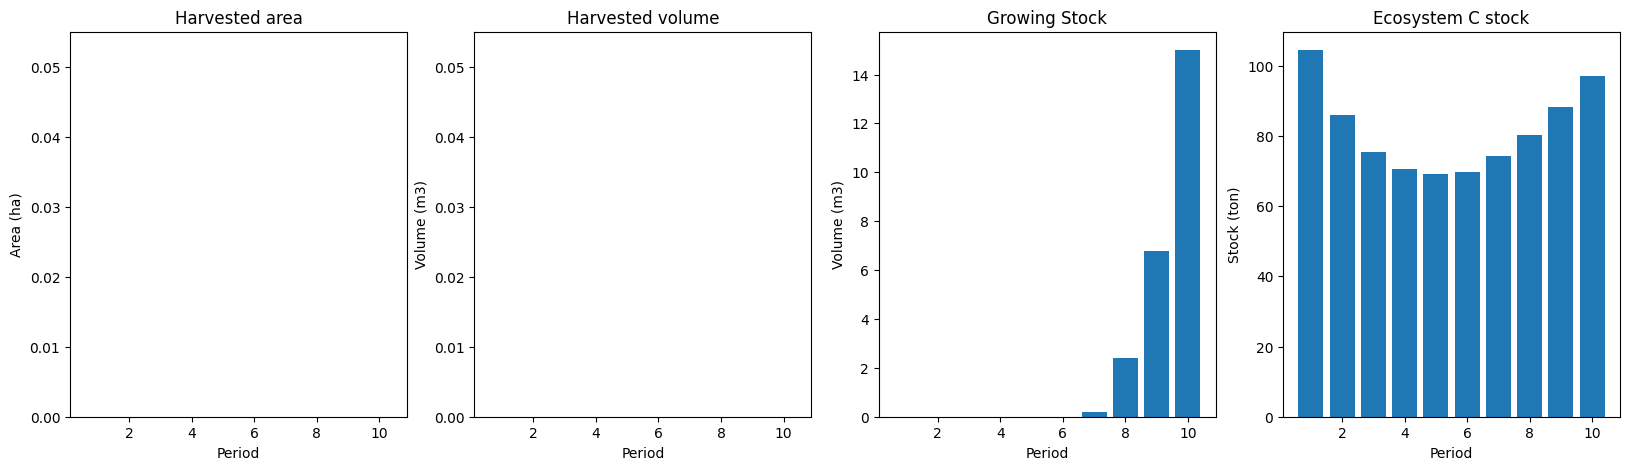

In [17]:
df = compile_scenario_maxstock(fm)
fig, ax = plot_scenario_maxstock(df)

In [18]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [19]:
#Generate New Sit_events file
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [20]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [21]:
sit_events

Empty DataFrame
Columns: [theme0, theme1, theme2, theme3, theme4, theme5, species, using_age_class, min_softwood_age, max_softwood_age, min_hardwood_age, max_hardwood_age, MinYearsSinceDist, MaxYearsSinceDist, LastDistTypeID, MinTotBiomassC, MaxTotBiomassC, MinSWMerchBiomassC, MaxSWMerchBiomassC, MinHWMerchBiomassC, MaxHWMerchBiomassC, MinTotalStemSnagC, MaxTotalStemSnagC, MinSWStemSnagC, MaxSWStemSnagC, MinHWStemSnagC, MaxHWStemSnagC, MinTotalStemSnagMerchC, MaxTotalStemSnagMerchC, MinSWMerchStemSnagC, MaxSWMerchStemSnagC, MinHWMerchStemSnagC, MaxHWMerchStemSnagC, efficiency, sort_type, target_type, target, disturbance_type, disturbance_year]
Index: []

[0 rows x 39 columns]

In [22]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Biomass         DOM   Ecosystem  All_Emissions  Gross_Growth  \
Year                                                                   
0      0.000062  104.467724  104.467786       0.000000      0.000000   
1      0.000499  102.039676  102.040175       8.902981     -0.001738   
2      0.001684   99.785821   99.787505       8.264667     -0.004878   
3      0.003990   97.678510   97.682500       7.728199     -0.009847   
4      0.007793   95.697510   95.705303       7.266550     -0.016828   
...         ...         ...         ...            ...           ...   
96    34.223901   67.995974  102.219875       6.891551     -9.428468   
97    34.638122   68.265614  102.903736       6.956030     -9.463520   
98    35.050318   68.530245  103.580563       7.016812     -9.498510   
99    35.460575   68.790626  104.251201       7.074400     -9.533407   
100   35.909715   69.047898  104.957613       7.129451     -9.719629   

      Stock_Change  Net_Emissions  
Year                               
0         0.000000       0.000000  
1         2.427612       8.901243  
2         2.252670       8.259789  
3         2.105005       7.718352  
4         1.977197       7.249723  
...            ...            ...  
96       -0.691886      -2.536917  
97       -0.683861      -2.507490  
98       -0.676827      -2.481698  
99       -0.670638      -2.459007  
100      -0.706412      -2.590177  

[101 rows x 7 columns]

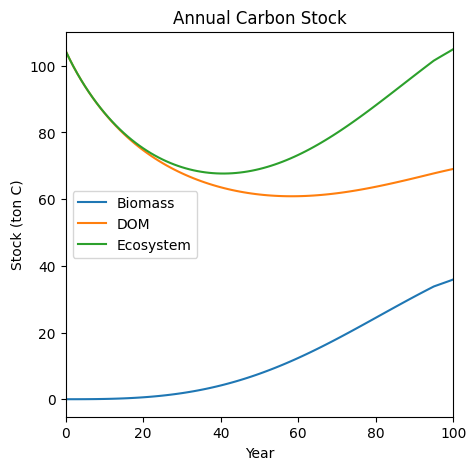

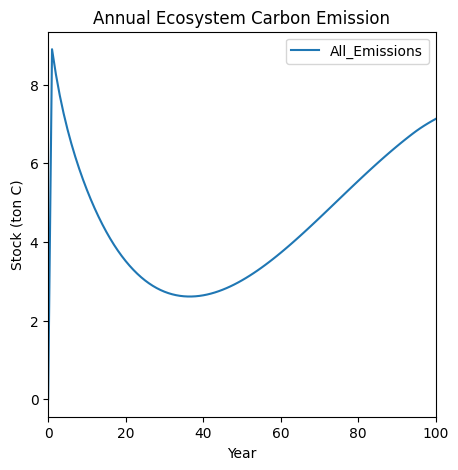

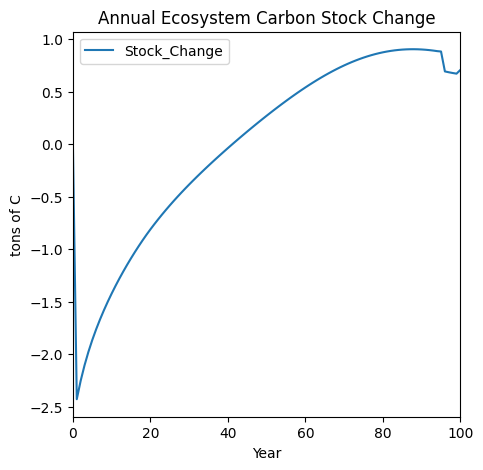

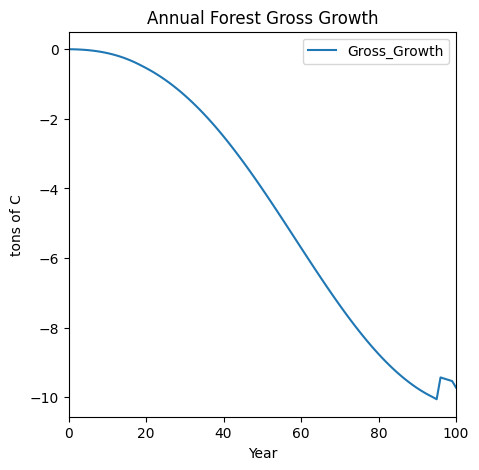

In [23]:
# Report Annual CBM Outputs
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)
cbm_report_both(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

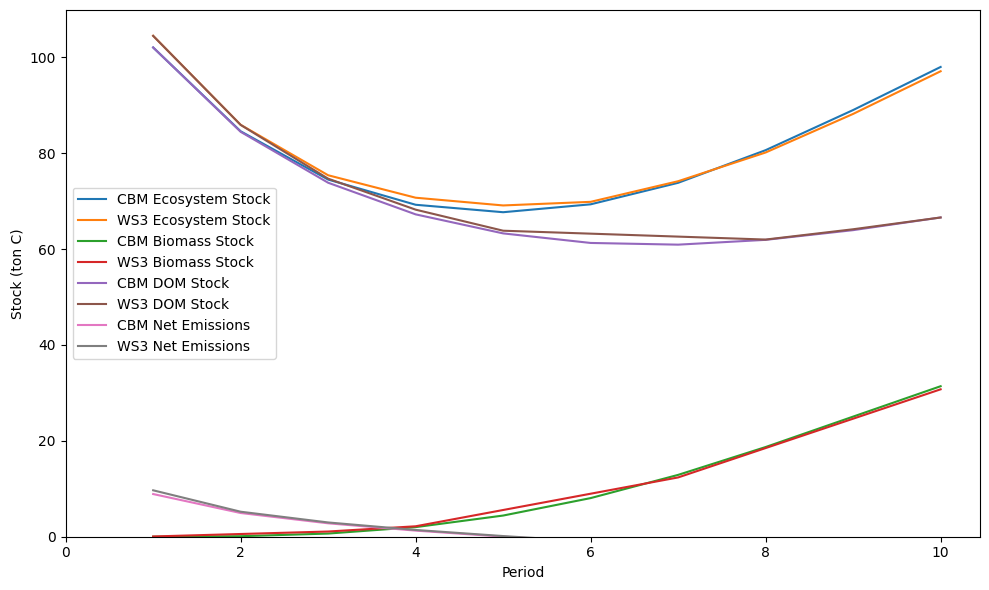

(   period  biomass_stock   dom_stock   eco_stock  ecosystem_decay_emissions  \
 0       1       0.000499  102.039676  102.040175                   8.902981   
 1       2       0.107615   84.452069   84.559684                   5.083002   
 2       3       0.659502   73.828249   74.487751                   3.398123   
 3       4       2.002497   67.232460   69.234957                   2.699388   
 4       5       4.416511   63.264183   67.680694                   2.662406   
 5       6       8.057009   61.270791   69.327800                   3.081382   
 6       7      12.898948   60.915471   73.814419                   3.806557   
 7       8      18.706643   61.917487   80.624130                   4.703761   
 8       9      25.052181   63.940702   88.992883                   5.644479   
 9      10      31.391409   66.585420   97.976829                   6.515378   
 
    gross_growth  net_emissions  eco_stock_change  
 0     -0.001738       8.901243          0.000000  
 1     -0.1371

In [24]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='whole')
compare_ws3_cbm_both(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, ecosystem_decay_emissions_pools, GrossGrowth_pools, plots="whole")

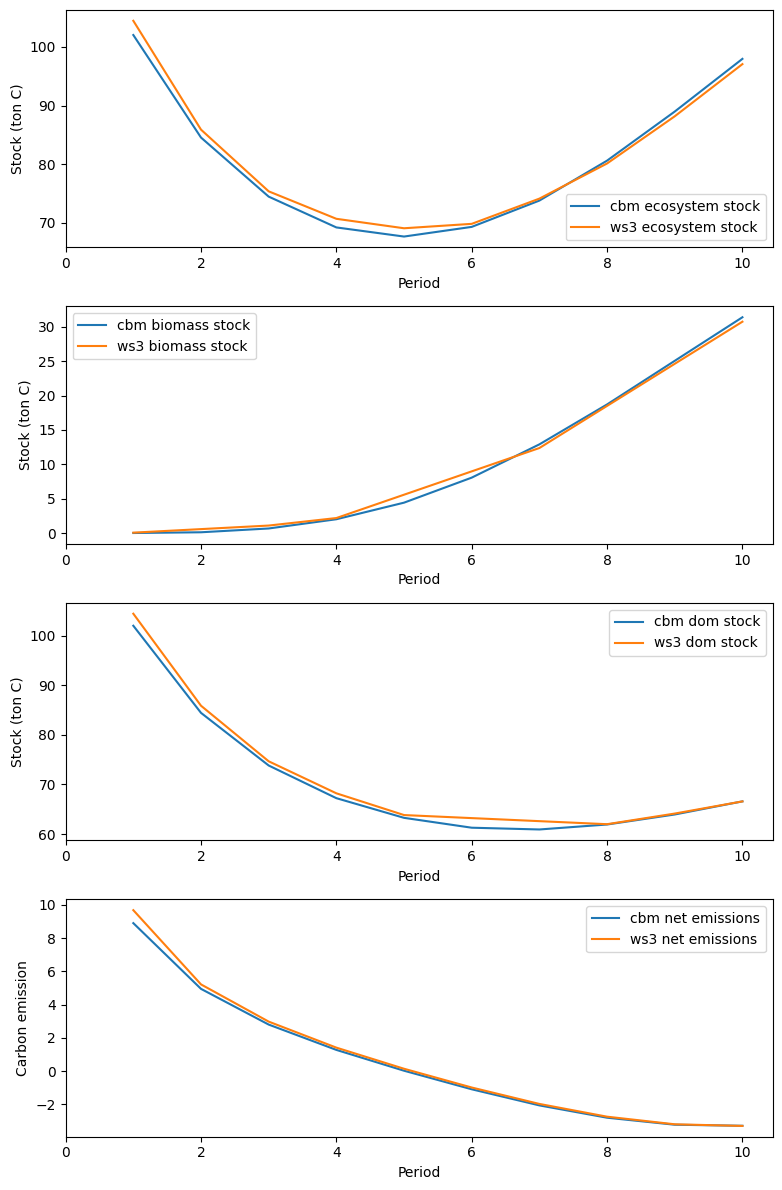

(   period  biomass_stock   dom_stock   eco_stock  ecosystem_decay_emissions  \
 0       1       0.000499  102.039676  102.040175                   8.902981   
 1       2       0.107615   84.452069   84.559684                   5.083002   
 2       3       0.659502   73.828249   74.487751                   3.398123   
 3       4       2.002497   67.232460   69.234957                   2.699388   
 4       5       4.416511   63.264183   67.680694                   2.662406   
 5       6       8.057009   61.270791   69.327800                   3.081382   
 6       7      12.898948   60.915471   73.814419                   3.806557   
 7       8      18.706643   61.917487   80.624130                   4.703761   
 8       9      25.052181   63.940702   88.992883                   5.644479   
 9      10      31.391409   66.585420   97.976829                   6.515378   
 
    gross_growth  net_emissions  eco_stock_change  
 0     -0.001738       8.901243          0.000000  
 1     -0.1371

In [25]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='individual')
compare_ws3_cbm_both(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, ecosystem_decay_emissions_pools, GrossGrowth_pools, plots="individual")

## Maximize the Total System Carbon Stock

In [26]:
def select_obj(obj_mode):
    print(f"Selected scenario: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='min_em',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Objective:', index=3, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='min_em')

In [27]:
obj_mode = obj_dropdown.value

In [28]:
from util_opt import cmp_c_ss, cmp_c_se

running no constraints scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 1024 columns and 1024 nonzeros
Model fingerprint: 0xe8be96cb
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1024 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4710383e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.471038267e+00


[(('tsa04', '1', '7', '100', '7', '7'), 1, 1.0, 'harvest', 1, '_existing')]

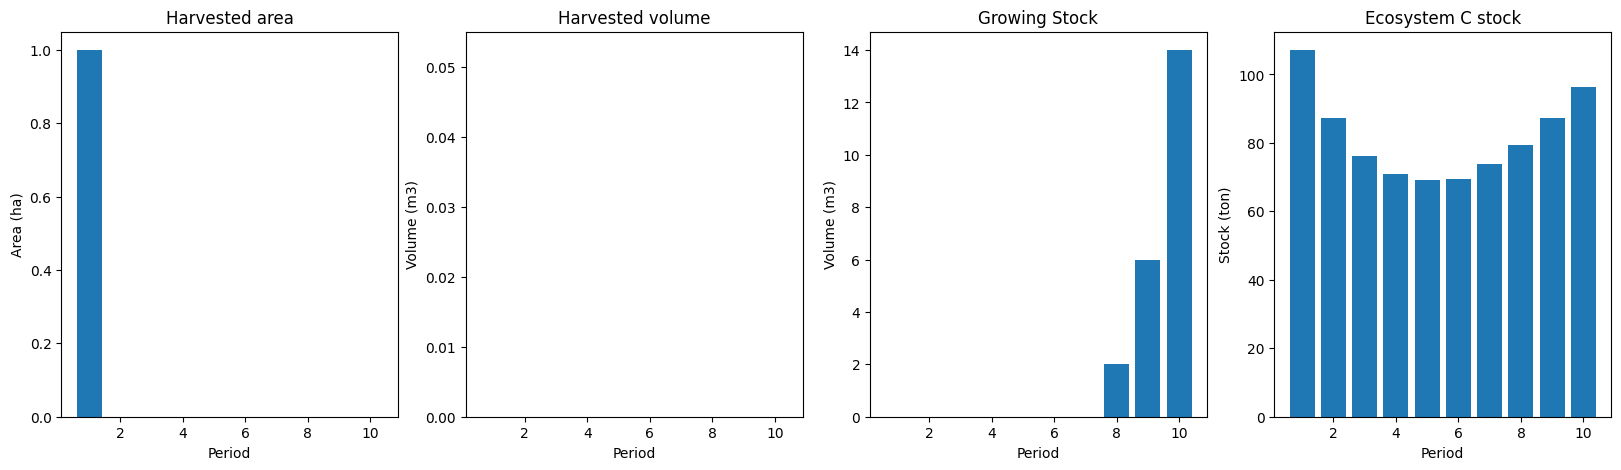

In [29]:
# Maximize Harvest
run_scenario(fm, obj_mode , 'no_cons')

In [30]:
# fm.applied_actions

(<Figure size 1600x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
    period  solid_wood  paper  sum_product   ecosystem      system
 0       1         0.0    0.0          0.0  107.108168  107.108168
 1       2         0.0    0.0          0.0   87.369348   87.369348
 2       3         0.0    0.0          0.0   76.061804   76.061804
 3       4         0.0    0.0          0.0   70.866993   70.866993
 4       5         0.0    0.0          0.0   69.254327   69.254327
 5       6         0.0    0.0          0.0 

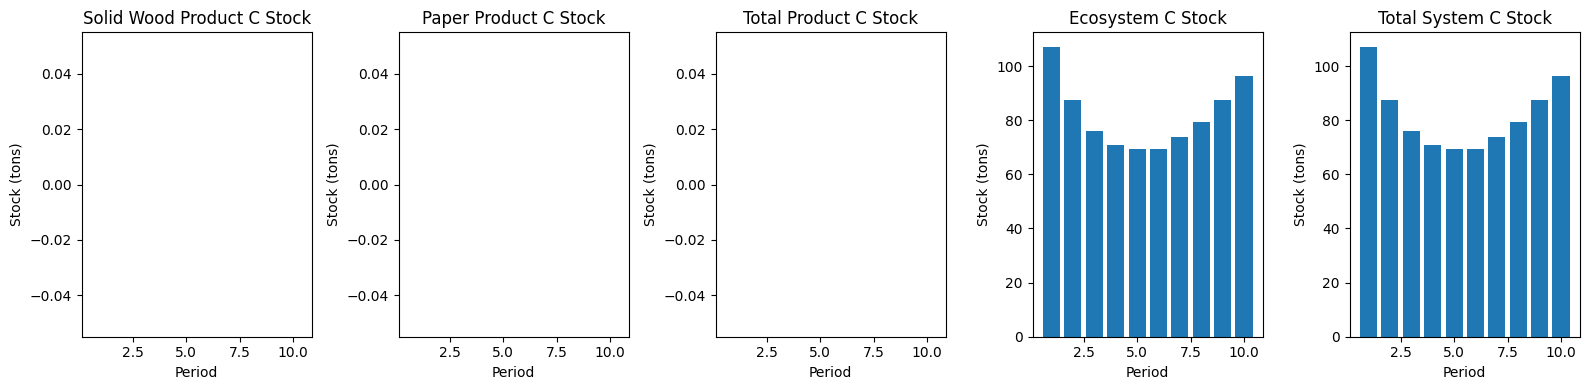

In [31]:
track_system_stock(fm)

(<Figure size 1600x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
    period  solid_wood  paper  sum_product  ecosystem     system
 0       1         0.0    0.0          0.0  -9.681401  -9.681401
 1       2         0.0    0.0          0.0  72.375676  72.375676
 2       3         0.0    0.0          0.0  41.460994  41.460994
 3       4         0.0    0.0          0.0  19.047640  19.047640
 4       5         0.0    0.0          0.0   5.913108   5.913108
 5       6     

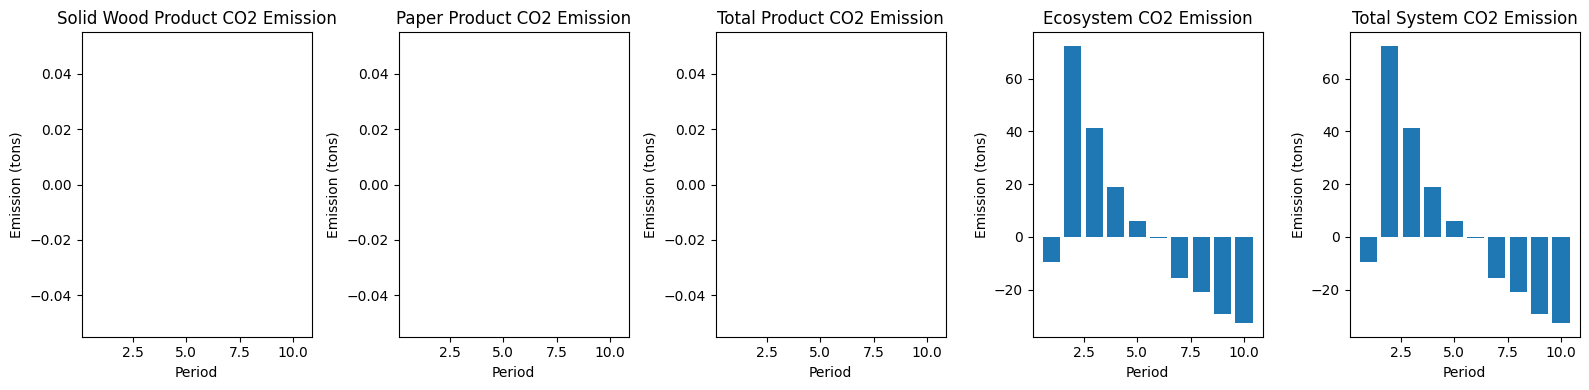

In [33]:
track_system_emission(fm)